In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_openml

import matplotlib.pyplot as  plt
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('svg')

import sys
from torchsummary import summary
import copy

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [3]:
data = np.loadtxt(open('sample_data/mnist_train_small.csv'), delimiter=',')

data = data[:, 1:] # No need to store labels as all are labeled to be real iamges
print(data.shape)

data = data/np.max(data)
data = 2*data - 1

data = torch.tensor( data ).float()
batchSize = 100 # Custom implementation of batches
data.shape

(20000, 784)


torch.Size([20000, 784])

# Discriminator Class

In [4]:
class discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 1)

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = self.fc3(x)
        return torch.sigmoid(x)

dnet = discriminator()
dnet(torch.randn((10, 784)))

tensor([[0.5372],
        [0.5041],
        [0.5454],
        [0.5538],
        [0.5593],
        [0.5379],
        [0.5396],
        [0.5235],
        [0.5484],
        [0.5464]], grad_fn=<SigmoidBackward0>)

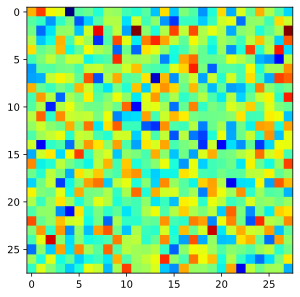

In [5]:
class generator(nn.Module):
    def __init__(self):
        super().__init__()

        self.fc1 = nn.Linear(64, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 784)

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = self.fc3(x)
        return torch.tanh(x)

gnet = generator()
plt.imshow(gnet(torch.randn((3, 64))).detach()[0,:].view(28,28), cmap='jet')
plt.show()

In [6]:
loss_fxn = nn.BCELoss()

gnet = generator().to(device)
dnet = discriminator().to(device)

d_optmiser = torch.optim.Adam(dnet.parameters(), lr=0.0003)
g_optmiser = torch.optim.Adam(gnet.parameters(), lr=0.0003)

In [ ]:
epoches = 50000
batchSize = 100 # Custom implementation of batches

losses = np.zeros((epoches, 2))
discriminator_decesion = np.zeros((epoches, 2))

for epoch in range(epoches):
    # Batch Creation
    random_index = torch.randint(data.shape[0], (batchSize,))
    real_images = data[random_index,:].to(device)
    fake_images = gnet(torch.randn( (batchSize, 64) ).to(device))

    real_labels = torch.ones((batchSize, 1)).to(device)
    fake_labels = torch.zeros((batchSize, 1)).to(device)


    # ================   Training starts - Discriminator   =================
    y__real = dnet(real_images)
    loss_real_disc = loss_fxn(y__real, real_labels)

    y__fake = dnet(fake_images)
    loss_fake_disc = loss_fxn(y__fake, fake_labels)

    loss_disc = loss_fake_disc + loss_real_disc
    losses[epoch,0] = loss_disc.item()
    discriminator_decesion[epoch,0] = torch.mean((y__real > 0.5).float()).detach()

    d_optmiser.zero_grad()
    loss_disc.backward()
    d_optmiser.step()




    # ================   Training starts - Discriminator   =================
    fake_images = gnet(torch.randn( (batchSize, 64) ).to(device))  # Create New Fake Images
    y__fake = dnet(fake_images)

    loss_generator = loss_fxn(y__fake, real_labels)

    losses[epoch,1] = loss_generator.item()
    discriminator_decesion[epoch,1] = torch.mean((y__fake > 0.5).float()).detach()

    g_optmiser.zero_grad()
    loss_generator.backward()
    g_optmiser.step()


    if (epoch+1)%100 == 0:
        sys.stdout.write('\r' + "Epoch No ->> " + str(epoch+1))

Epoch No ->> 14500

In [ ]:
fig, ax = plt.subplots(1,3,figsize=(12,4))

ax[0].plot(losses)
ax[0].legend(['Discriminator', 'Generator'])
ax[0].set_ylabel("Loss")
ax[0].set_xlabel("Epoch")
ax[0].set_title("ModeL Loss")
ax[0].grid()
# ax[0].set_ylim([1,2])


ax[1].plot(losses[::5,0], losses[::5,1], 'k.', alpha=0.1)
ax[1].set_ylabel("Discriminator Loss")
ax[1].set_xlabel("Generator Loss")
ax[1].set_title("Correlation of loss")
ax[1].grid()


ax[2].plot(discriminator_decesion)
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('Probablity ("real")')
ax[2].set_title('Discriminator output')
ax[2].legend(['Real','Fake'])
ax[2].grid()

plt.show()

In [ ]:
gnet.eval()
fake_data = gnet(torch.randn(12,64).to(device)).cpu()


fig,axs = plt.subplots(3,4,figsize=(8,6))
for i,ax in enumerate(axs.flatten()):
    lets_see = dnet(fake_data[i,:,].to(device)).detach().item() > 0.5

    cmp = 'gray' if lets_see else 'hot'
    ax.imshow(fake_data[i,:,].detach().view(28,28),cmap=cmp)
    ax.set_title(f"Dscrmtr Pred : {lets_see}")
    ax.axis('off')

plt.tight_layout()
plt.show()